# Starbucks Promotional Offers Data Project (EDA Notebook)

In [1]:
# Import Python data modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import other functions
from sqlalchemy import create_engine
from scipy.stats import linregress

## Importing Data

In [2]:
# Create a connection to the MySQL database
user = 'root'
hidden = 'Basketba11isgood' 
host = 'localhost'
port = '3306'
database = 'starbucks_promotions_db'

connection = create_engine(f'mysql+mysqlconnector://{user}:{hidden}@{host}:{port}/{database}')

In [3]:
# Read in data from the SQL Database
offers = pd.read_sql('SELECT * FROM offers', con=connection)
customers = pd.read_sql('SELECT * FROM customers', con=connection)
transactions = pd.read_sql('SELECT * FROM transactions', con=connection)
offers_received = pd.read_sql('SELECT * FROM offers_received', con=connection)
offers_viewed = pd.read_sql('SELECT * FROM offers_viewed', con=connection)
offers_completed = pd.read_sql('SELECT * FROM offers_completed', con=connection)

## Exploratory Data Analysis

Check to see how offers performed throughout the 30 day period

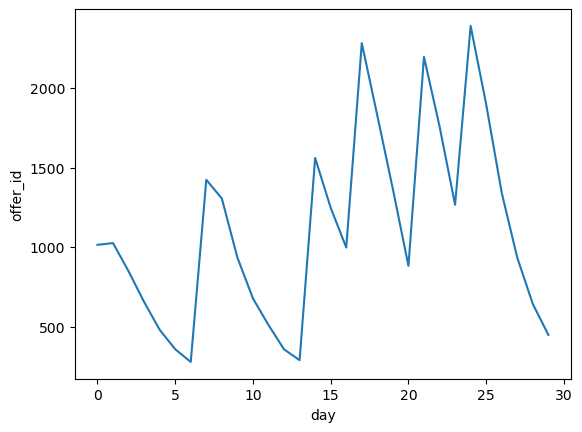

In [4]:
# Create the table to plot the offers completed throughout the 30 day period
num_completed_by_day = offers_completed.groupby('day')['offer_id'].count()  
fig, ax = plt.subplots()
sns.lineplot(num_completed_by_day, ax=ax)
plt.show()

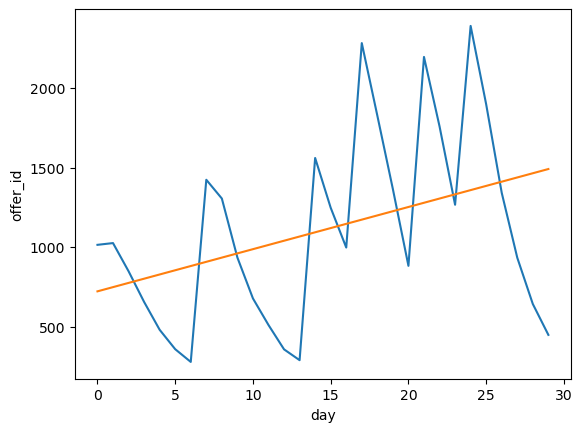

(0.03661413822039195, 26.513459399332593, 0.14681750867457152)

<Figure size 640x480 with 0 Axes>

In [5]:
# Plot a trend line to see the general upward increase
x = num_completed_by_day.index
y = num_completed_by_day
fig, ax = plt.subplots()
sns.lineplot(num_completed_by_day, ax=ax)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), label='Trend line')
plt.show()
plt.clf()
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Check the p_value, slope, and r_value^2 of the trend line
p_value, slope, r_value ** 2

Although highly volitile, offers were completed at an increasing statistically significant (p = 0.04) rate of 26.5 more completions per day throughout the 30 day period

In [6]:
# Check to see what days offers are released
offers_received['day'].value_counts().sort_index()

day
0     12650
7     12669
14    12711
17    12778
21    12704
24    12765
Name: count, dtype: int64

In [7]:
# Find out the average amount of times an offer was sent out per release day per offer
(offers_received.merge(offers[['offer_id', 'offer_type']], how='inner', on='offer_id')
                .pivot_table(index='day', columns='offer_id', values='hour', aggfunc='count', observed=False)
                .mean()
                .mean()
                .round(1)
)

1271.3

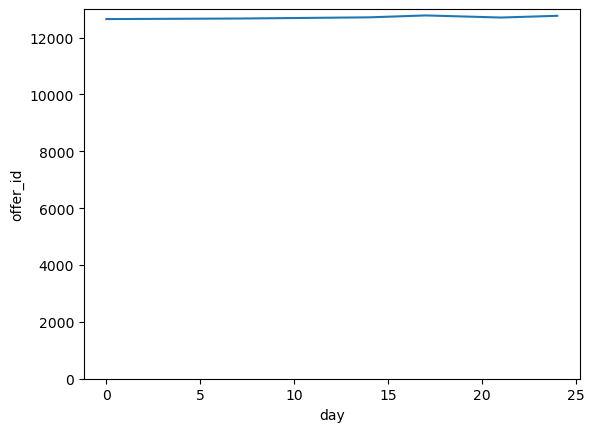

In [8]:
# Plot a line graph of offers received throughout the 30 day period to see if there are any changes
fig, ax = plt.subplots()
sns.lineplot(offers_received.groupby('day')['offer_id'].count(), ax=ax)
ax.set_ylim(0, 13000)
plt.show()

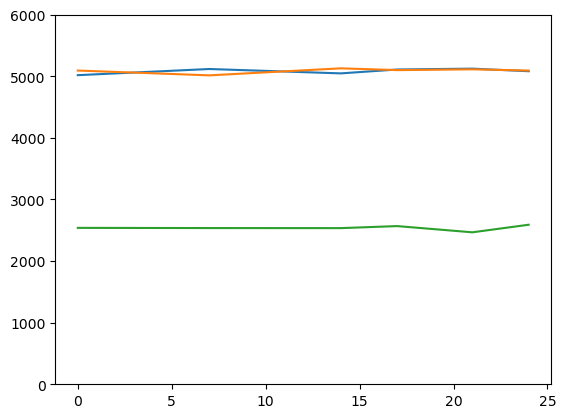

<Figure size 640x480 with 0 Axes>

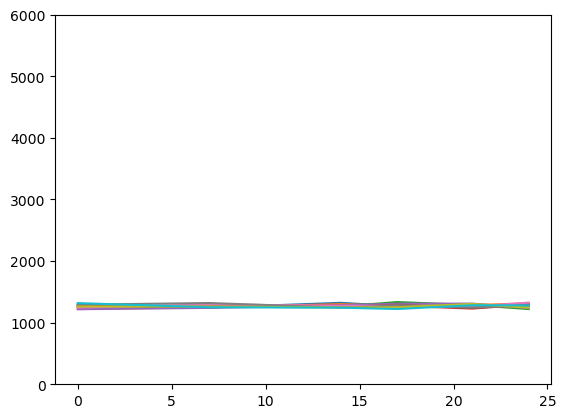

<Figure size 640x480 with 0 Axes>

In [9]:
# Create the DataFrame that will be used to plot the offers recieved by offer type
offers_received_plot = (offers_received.merge(offers[['offer_id', 'offer_type']], how='inner', on='offer_id')
                                       .pivot_table(index='day', columns='offer_type', values='hour', aggfunc='count', observed=False))

# Create the DataFrame that will be used to plot the offers recieved by individual offer
offerID_received_plot = offers_received.pivot_table(index='day', columns='offer_id', values='hour', aggfunc='count', observed=False)

# Plot offers recieved by offer type and offer id respectively to see if there are any changes in which offers were sent out
for offers_plot in [offers_received_plot, offerID_received_plot]:
    fig, ax = plt.subplots()
    ax.plot(offers_plot)
    #ax.set_title()
    ax.set_ylim(0, 6000)
    plt.show()
    plt.clf()

The above analysis reveals the following:
- Offers were released on days 0, 7, 14, 17, 21, and 24
- On each of the release days, each offer was sent out 1271 times on average
- The total amount of offers sent out remained consistent throughout the 30 days.
- Each offer was sent out similar amounts of times with little change througjhout the 30 days

In [10]:
# Get the offerid_performance view created in SQL
performance = pd.read_sql('SELECT * FROM offerid_performance', con=connection)

# Check to make sure the table loaded in correctly
performance.head()

,offer_id,num_completed,offer_type,total_discounted_amount,total_due_amount,total_cm_saved_amount,difficulty,reward,duration
0,fafdcd668e3743c1bb461111dcafc2a4,5265,discount,96900.0,107430.0,10530.0,10,2,10
1,2298d6c36e964ae4a3e7e9706d1fb8c2,5112,discount,89848.0,105184.0,15336.0,7,3,7
2,ae264e3637204a6fb9bb56bc8210ddfd,3635,bogo,87110.0,123460.0,36350.0,10,10,7
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,3340,discount,85986.0,102686.0,16700.0,20,5,10
4,f19421c1d4aa40978ebb69ca19b0e20d,4262,bogo,83147.0,104457.0,21310.0,5,5,5


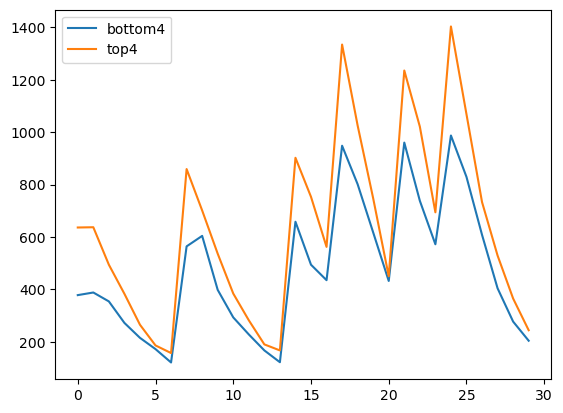

<Figure size 640x480 with 0 Axes>

In [11]:
# Create a column in the offers_completed table that says if an offer was a higher performer of not (top 4/bottom 4) excluding info offers
offers_completed['performance_group'] = np.where(offers_completed['offer_id'].isin(list(performance.sort_values('num_completed', ascending=False)['offer_id'].iloc[:4])), 
                                                 'top4', 
                                                 'bottom4'
                                                )

# Filter out informational offers
performance_offers_completed = offers_completed[offers_completed['offer_id'].isin(list(performance['offer_id']))]

# Create the DataFrame that will be used to plot the offers completed by performance (top 4/bottom 4)
performance_completed_plot = performance_offers_completed.pivot_table(
    index='day', 
    columns='performance_group', 
    values='hour', 
    aggfunc='count', 
    observed=False)

# Plot the offers completed by performance (top 4/bottom 4)
fig, ax = plt.subplots()
ax.plot(performance_completed_plot)
#ax.set_title()
ax.legend(performance_completed_plot.columns)
plt.show()
plt.clf()

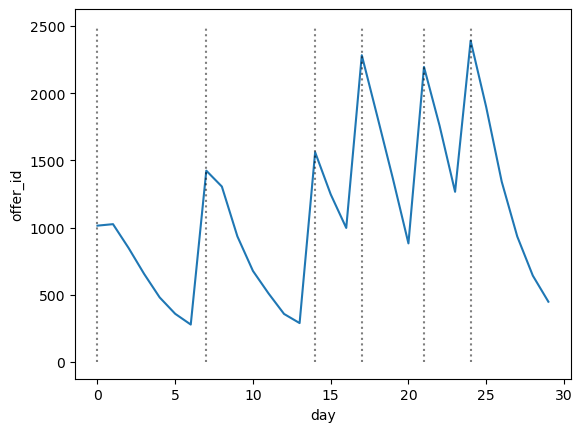

In [12]:
# Check to see if the increase in offers completed is because its on release days  
fig, ax = plt.subplots()
sns.lineplot(num_completed_by_day, ax=ax)
ax.vlines(offers_received_plot.index, 0, 2500, linestyle=':', alpha=0.5, color='black')
plt.show()

This seems to be the most likely cause. I will still inspect other possible causes.

In [13]:
# Check the total completed offers by offer
performance.groupby('offer_type')['num_completed'].sum()

offer_type
bogo        15501
discount    17681
Name: num_completed, dtype: int64

In [14]:
# Find out by how much offers completed increased on offer release days compared to the day before
release_day_completed_increase = {}
for release_day in offers_received['day'].unique():
    if release_day == 0:
        release_day_completed_increase[release_day] = num_completed_by_day.loc[0]
    else:
        release_day_completed_increase[release_day] = num_completed_by_day.loc[release_day] - num_completed_by_day.loc[release_day - 1]
release_day_completed_increase

{0: 1014, 7: 1145, 14: 1271, 17: 1285, 21: 1313, 24: 1124}

In [15]:
# Find the average increase
np.mean(list(release_day_completed_increase.values()))

1192.0

Investigate the offers viewed performance

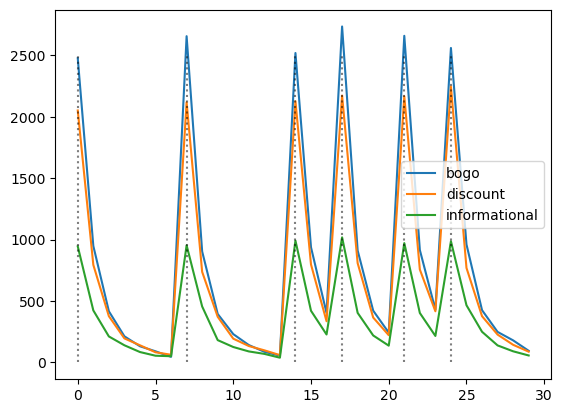

In [16]:
# Create the DataFrame that will be used to plot the offers viewed by individual offer
offers_viewed_plot = (offers_viewed.merge(offers[['offer_id', 'offer_type']], how='inner', on='offer_id')
                                   .pivot_table(index='day', columns='offer_type', values='hour', aggfunc='count', observed=False))

# Plot the offers viewed by individual offer
fig, ax = plt.subplots()
ax.plot(offers_viewed_plot)
ax.legend(offers_viewed_plot.columns)
ax.vlines(offers_received_plot.index, 0, 2500, linestyle=':', alpha=0.5, color='black')
plt.show()

<Axes: xlabel='day', ylabel='count'>

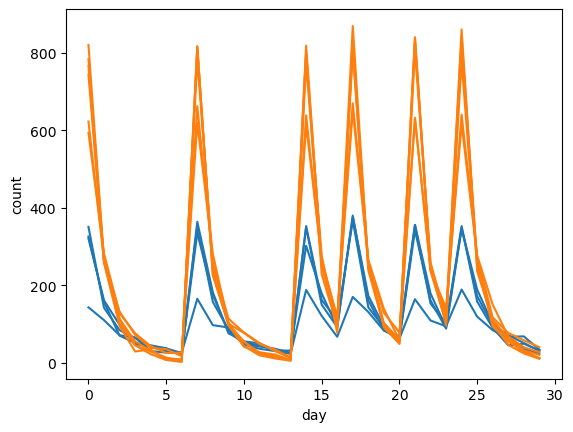

In [17]:
offer_daily_viewed = offers_viewed.groupby(['day', 'offer_id']).size().reset_index(name='count').merge(offers[['offer_id', 'social']], how='inner', on='offer_id')

sns.lineplot(data=offer_daily_viewed, x='day', y='count', hue='social', style='offer_id', dashes=False, legend=False)

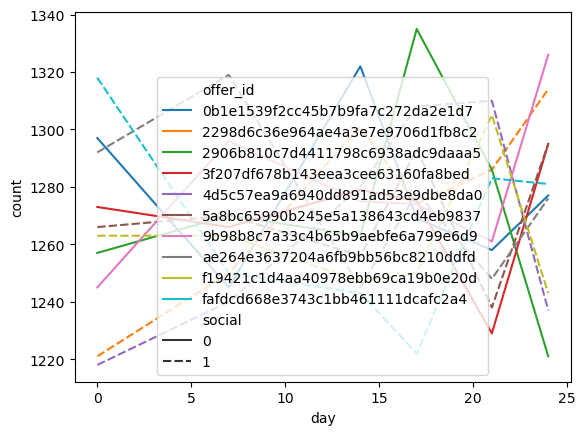

In [18]:
offer_daily_received = offers_received.groupby(['day', 'offer_id']).size().reset_index(name='count').merge(offers[['offer_id', 'social']], how='inner', on='offer_id')

fig, ax = plt.subplots()
sns.lineplot(data=offer_daily_received, x='day', y='count', hue='offer_id', style='social', legend=True, ax=ax)
plt.show()

In [19]:
social_daily_received = offers_received.merge(offers[['offer_id', 'social']], how='inner', on='offer_id').groupby(['day', 'social']).size().reset_index(name='count')

<Axes: xlabel='day', ylabel='count'>

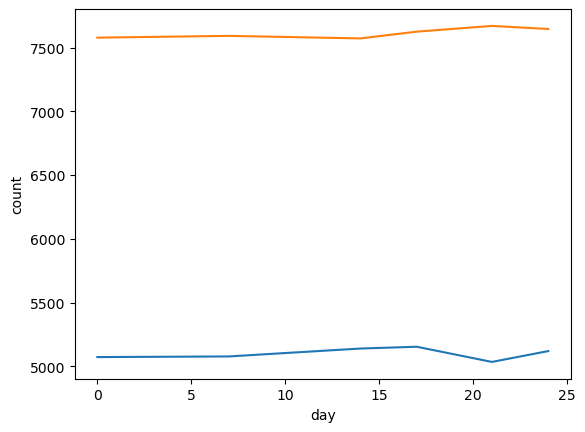

In [20]:
sns.lineplot(data=social_daily_received, x='day', y='count', hue='social', legend=False)

<Axes: xlabel='day'>

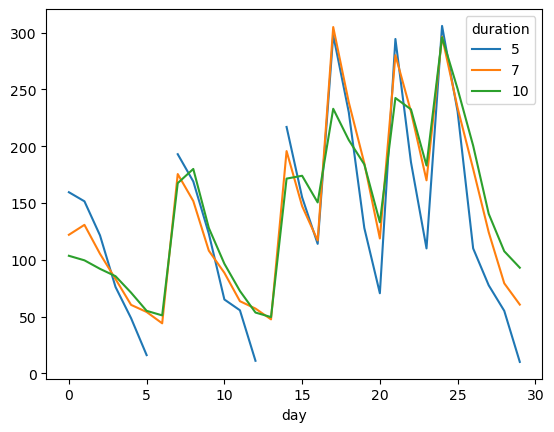

In [21]:
completed_duration = offers_completed[['offer_id', 'reward', 'due_amount', 'day']].merge(offers[['offer_id', 'offer_type', 'duration']], how='inner', on='offer_id')

completed_duration.groupby(['day', 'duration', 'offer_id'])[['reward']].count().reset_index().pivot_table(index='day', columns='duration', values='reward', aggfunc='mean').plot()

In [22]:
offers[offers['offer_type'] == 'discount']['duration'].value_counts()

duration
10    2
7     2
Name: count, dtype: int64

In [23]:
offers[offers['offer_type'] == 'bogo']['duration'].value_counts()

duration
7    2
5    2
Name: count, dtype: int64

<Axes: xlabel='day'>

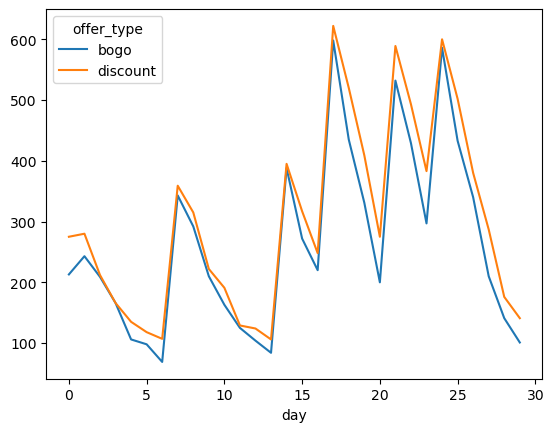

In [24]:
completed_duration7 = completed_duration[completed_duration['duration'] == 7]

completed_duration7.groupby(['day', 'offer_type'], observed=True)[['offer_id']].count().reset_index().pivot(index='day', columns='offer_type', values='offer_id').plot()

In [25]:
offers_completed_offers = offers_completed.merge(offers.drop('reward', axis=1), how='inner', on='offer_id')
offer_type_totals = offers_completed_offers.groupby('offer_type', observed=True)[['difficulty', 'reward', 'discounted_amount', 'due_amount']].sum()

In [26]:
offer_type_totals

,difficulty,reward,discounted_amount,due_amount
offer_type,,,,
bogo,112185,112185.0,325885.32,438070.32
discount,194874,50494.0,354421.73,404915.73


In [27]:
offers_completed_offers.groupby('offer_type', observed=True)[['difficulty', 'reward', 'discounted_amount', 'due_amount']].mean()

,difficulty,reward,discounted_amount,due_amount
offer_type,,,,
bogo,7.237275,7.237275,21.023503,28.260778
discount,11.021662,2.855834,20.045344,22.901178


In [28]:
offers_completed_offers.groupby('offer_type', observed=True)[['offer_id']].count()

,offer_id
offer_type,
bogo,15501
discount,17681


In [29]:
standardise_percentage = 15501/17681
standardised_totals = pd.concat([offer_type_totals.loc[['bogo']], offer_type_totals.loc[['discount']] * standardise_percentage])

In [30]:
standardised_totals

,difficulty,reward,discounted_amount,due_amount
offer_type,,,,
bogo,112185.000000,112185.000000,325885.320000,438070.32000
discount,170846.777558,44268.281998,310722.879743,354991.16174


In [31]:
standardised_totals.loc['bogo', 'reward'] - standardised_totals.loc['discount', 'reward']

67916.71800237543

In [32]:
standardised_totals.loc['bogo', 'discounted_amount'] - standardised_totals.loc['discount', 'discounted_amount']

15162.4402573384

In [33]:
offer_type_totals.loc['bogo', 'reward'] - offer_type_totals.loc['discount', 'reward']

61691.0

In [34]:
offer_type_totals.loc['bogo', 'discounted_amount'] - offer_type_totals.loc['discount', 'discounted_amount']

-28536.409999999974

## Report Visualisations

In [35]:
# Change default formatting for Matplotlib and Seaborn for this file
plt.rc('axes.spines', right=False, top=False)
plt.rc('font', family='Times New Roman')
plt.rc('axes', labelweight='normal', titleweight='bold')

# Assign Starbucks green to a specific variable
green = '#0b7142'

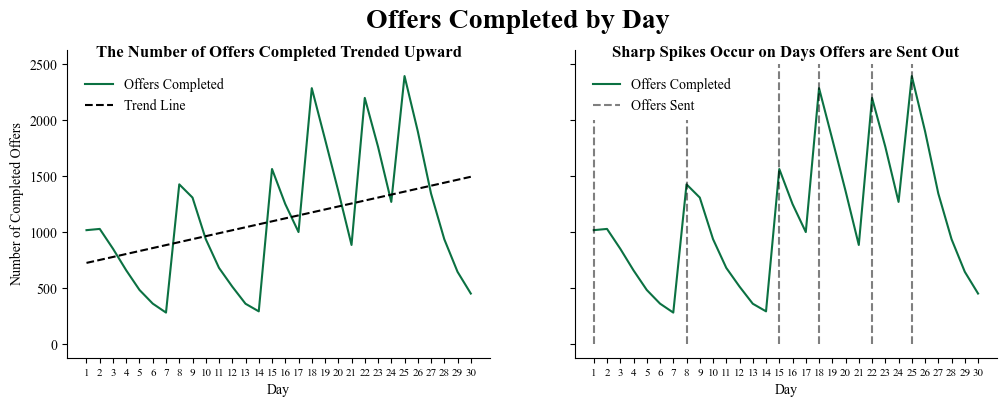

In [36]:
#num_completed_by_day = offers_completed.groupby('day')['offer_id'].count()
#x = num_completed_by_day.index
#y = num_completed_by_day


fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
fig.suptitle("Offers Completed by Day", fontsize=20, fontweight='bold')

sns.lineplot(num_completed_by_day, ax=ax[0], color=green, label='Offers Completed')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax[0].set_title('The Number of Offers Completed Trended Upward', y=0.95)
ax[0].plot(x, p(x), label='Trend Line', color='Black', linestyle='--')
ax[0].set_xticks(num_completed_by_day.index)
ax[0].set_xticklabels(num_completed_by_day.index + 1, fontsize=8)
ax[0].set_ylabel('Number of Completed Offers')
ax[0].set_xlabel('Day')
ax[0].legend(bbox_to_anchor=(0.4, 0.95), frameon=False)


sns.lineplot(num_completed_by_day, ax=ax[1], color=green, label='Offers Completed')
ax[1].set_title('Sharp Spikes Occur on Days Offers are Sent Out', y=0.95)
ax[1].vlines(offers_received_plot.index[2:], 0, 2500, linestyle='--', alpha=0.5, color='black', label='Offers Sent')
ax[1].vlines(offers_received_plot.index[:2], 0, 2000, linestyle='--', alpha=0.5, color='black')
ax[1].set_xticks(num_completed_by_day.index)
ax[1].set_xticklabels(num_completed_by_day.index + 1, fontsize=8)
ax[1].set_xlabel('Day')
ax[1].legend(bbox_to_anchor=(0.4, 0.95), frameon=False)

plt.savefig('../ReportImages/OffersCompletedbyDay.png', dpi=1000)

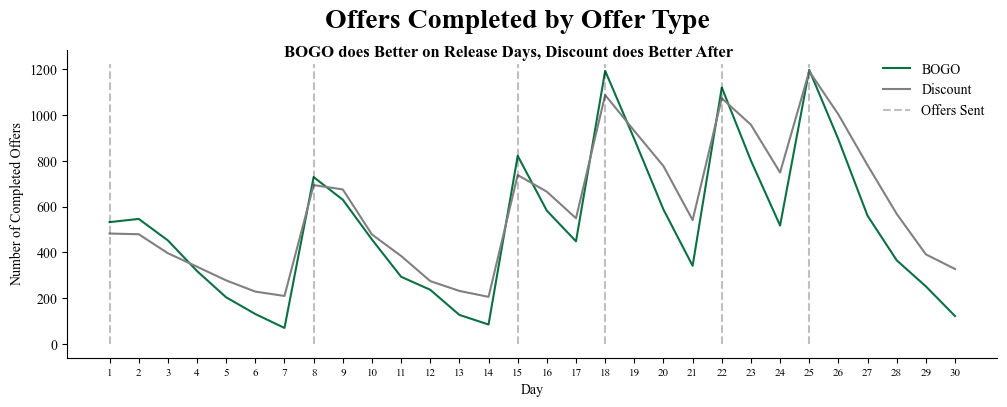

In [37]:
offers_completed_plot = (offers_completed.merge(offers[['offer_id', 'offer_type']], how='inner', on='offer_id')
                                         .pivot_table(index='day', columns='offer_type', values='hour', aggfunc='count', observed=False)
                        )
                        

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Offers Completed by Offer Type", fontsize=20, fontweight='bold')

ax.plot(offers_completed_plot['bogo'], color=green, label='BOGO')
ax.plot(offers_completed_plot['discount'], color='Gray', label='Discount')

ax.set_title('BOGO does Better on Release Days, Discount does Better After', x=0.475, y=0.95)
ax.set_xticks(num_completed_by_day.index)
ax.set_xticklabels(num_completed_by_day.index + 1, fontsize=8)
ax.set_xlabel('Day')
ax.set_ylabel('Number of Completed Offers')
ax.vlines(offers_received_plot.index, 0, 1225, linestyle='--', alpha=0.25, color='black', label='Offers Sent')
ax.legend(['BOGO', 'Discount', 'Offers Sent'], frameon=False)

plt.savefig('../ReportImages/OffersCompletedbyOfferType.png', dpi=1000)

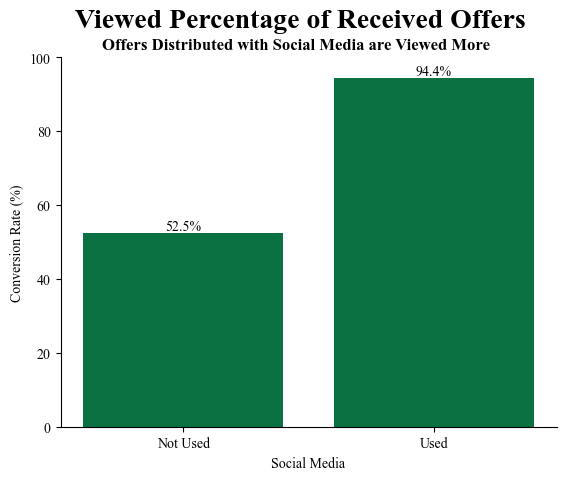

In [38]:
# Read in funnel_cm view
funnel_cm = pd.read_sql('SELECT * FROM funnel_cm', con=connection)

social_funnel_count = funnel_cm.merge(offers[['offer_id', 'social']], how='inner', on='offer_id').groupby('social').count()

view_conv_rate_social = (social_funnel_count['num_viewed'] * 100) / social_funnel_count['num_received']

fig, ax = plt.subplots()

fig.suptitle('Viewed Percentage of Received Offers', fontsize=20, fontweight='bold')

bars = ax.bar([0, 1], view_conv_rate_social, color=green)
ax.bar_label(bars, labels=[f'{height:.1f}%' for height in bars.datavalues])

ax.set_title('Offers Distributed with Social Media are Viewed More', x=0.475)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Not Used', 'Used'])
ax.set_xlabel('Social Media')
ax.set_ylim(0, 100)
ax.set_ylabel('Conversion Rate (%)')

plt.savefig('../ReportImages/PercentageViewedOffers', dpi=1000)

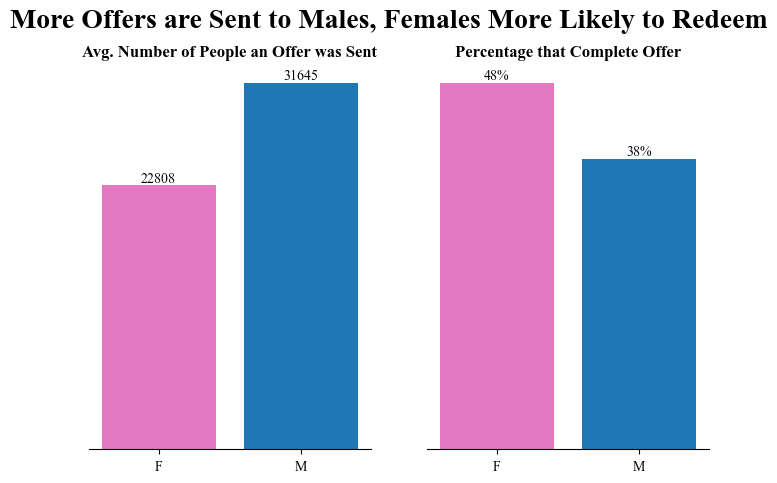

In [39]:
funnel_cm = funnel_cm.merge(customers, how='inner', on='customer_id')

funnel_gender = funnel_cm.groupby('gender', observed=False)[['num_received', 'num_viewed', 'num_completed']].count().drop('O')

funnel_gender['completed_percentage'] = funnel_gender['num_completed'] / funnel_gender['num_received']

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

fig.suptitle('More Offers are Sent to Males, Females More Likely to Redeem', fontsize=20, fontweight='bold', y=0.99)

bars = ax[0].bar(funnel_gender.index, funnel_gender['num_received'], color=['tab:Pink', 'tab:Blue'])
ax[0].bar_label(bars, labels=[f'{height:.0f}' for height in bars.datavalues])

ax[0].set_title('Avg. Number of People an Offer was Sent')
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(left=False)
ax[0].set_yticklabels([])

bars = ax[1].bar(funnel_gender.index, funnel_gender['completed_percentage'], color=['tab:Pink', 'tab:Blue'])
ax[1].bar_label(bars, labels=[f'{height * 100:.0f}%' for height in bars.datavalues])
ax[1].set_title('Percentage that Complete Offer')
ax[1].spines['left'].set_visible(False)
ax[1].tick_params(left=False)
ax[1].set_yticklabels([])

plt.savefig('../ReportImages/GenderOfferEngagement', dpi=1000)
plt.show()

In [40]:
funnel_cm['income_group'] = funnel_cm['income'].round(-4)
funnel_cm['age_group'] = funnel_cm['age'].round(-1)

In [41]:
funnel_cm.dropna()
funnel_cm['young_or_not'] = np.where(funnel_cm['age_group'].isin((20, 30)), '20s and 30s', '40 and Over')

In [42]:
funnel_age_social = (funnel_cm.merge(offers[['offer_id', 'social']], how='inner', on='offer_id')
                              .groupby(['young_or_not', 'social'])[['num_received', 'num_viewed', 'num_completed']]
                              .count()
                              .reset_index())

In [43]:
funnel_age_social['viewed_percentage'] = funnel_age_social['num_viewed'] / funnel_age_social['num_received']

In [44]:
funnel_age_social

,young_or_not,social,num_received,num_viewed,num_completed,viewed_percentage
0,20s and 30s,0,3373,1110,584,0.329084
1,20s and 30s,1,5086,4898,2190,0.963036
2,40 and Over,0,21972,12191,5807,0.554843
3,40 and Over,1,32857,30936,15879,0.941535


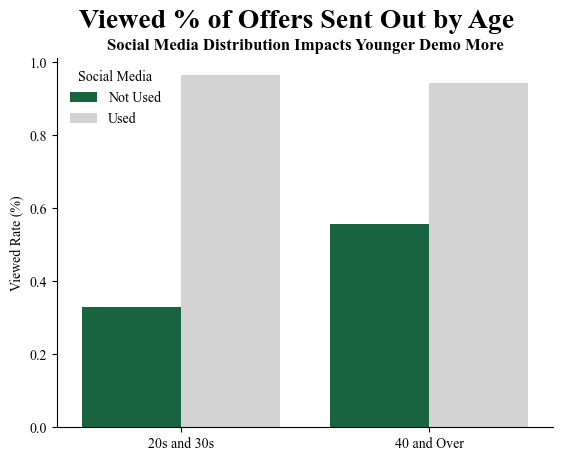

In [45]:
fig, ax = plt.subplots()

fig.suptitle('Viewed % of Offers Sent Out by Age', fontsize=20, fontweight='bold')

bars = sns.barplot(data=funnel_age_social, x='young_or_not', y='viewed_percentage', hue='social', ax=ax, palette={0: green, 1: '#D3D3D3'})

ax.set_title('Social Media Distribution Impacts Younger Demo More')
ax.set_ylabel('Viewed Rate (%)')
ax.set_xlabel('')


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[0], handles[1]], labels=['Not Used', 'Used'], title='Social Media', frameon=False)

plt.savefig('../ReportImages/ViewedPercentageAgeSocialMedia', dpi=1000)